<a href="https://colab.research.google.com/github/DavZhangDev/CEPMLTraining/blob/master/Image_Classifier_for_Skin_Cancer_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Classifier for Skin Cancer


This colab is the environment used to train the skin cancer model that is deployed on our website.

## Environment Set-up

In [1]:
# Mount drive to access dataset
from google.colab import drive
drive.mount('/content/gdrive')
path = "/content/gdrive/My Drive/skin-cancer-malignant-vs-benign"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# Tensorflow checking for Colab to run on GPU
import tensorflow as tf
if tf.test.gpu_device_name() == '/device:GPU:0':
    print("Using GPU.")
else:
    print("Using TPU.")

Using GPU.


In [3]:
# Libraries for constructing the neural network
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Activation, Dropout, Flatten, Dense

# Libraries for plotting and image processing
import numpy as np
import pandas as pd
from glob import glob
from sklearn.model_selection import train_test_split

# Libraries for plotting and visualitsation of model
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import confusion_matrix
from IPython.display import Image
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
# Define global variables for classifier to run on
IMAGE_WIDTH, IMAGE_HEIGHT = 200, 200
EPOCHS = 20
BATCH_SIZE = 32
num_classes = 2
classes = ['benign', 'malignant']
VALIDATION_SPLIT = 0.2

## Data Pipeline

In [5]:
# Define function to split dataset into train and test datasets
# Datasets are in the form of pandas dataframes that can be used by Keras layers
def trainValidSplit(path, split_percent):
  file_names = glob(path + '/**/*')
  benign_names = glob(path + '/benign/*')
  print("Number of benign images:", len(benign_names))
  malignant_names = glob(path + '/malignant/*')
  print("Number of malignant images:", len(malignant_names))
  all_classes = [file.split('/')[-2] for file in file_names]
  print("Total images:", len(all_classes))
  x_train, x_valid, y_train, y_valid = train_test_split(file_names, all_classes, test_size=split_percent, random_state=42)
  train_df = pd.DataFrame({'filename': x_train, 'class': y_train})
  validation_df = pd.DataFrame({'filename': x_valid, 'class': y_valid})
  return (train_df, validation_df)

# Calling on function to split data
train_df, validation_df = trainValidSplit(path, VALIDATION_SPLIT)

Number of benign images: 1497
Number of malignant images: 1497
Total images: 2994


In [6]:
# Define train and validation data generators settings

# Processing training data
training_data_generator = ImageDataGenerator(
    rescale=1./255, # Divides each pixel by 255 to obtain a float which represents the RGB value.
    shear_range=0.1, # Rotate image so the data would not have same orientation as validation data. Gives a more realistic accuracy reading.
    zoom_range=0.1, # Zooms image by 1.1 to account for different distances in taking pictures using webcam.
    horizontal_flip=True # Flips images randomly as abnormalities can be taken in different angles.
    )

# Validation data generator
validation_data_generator = ImageDataGenerator(
    rescale=1./255)

In [7]:
# Setup actual data generator

# Create training data generator
training_generator = training_data_generator.flow_from_dataframe(
    train_df,
    target_size = (IMAGE_WIDTH, IMAGE_HEIGHT), # Alter image dimension
    batch_size = BATCH_SIZE, # Makes batches for neural network to process
    shuffle = True, # Randomise image order
    class_mode = "categorical" # Image labels with classes
    )

# Create validation data generator
validation_generator = validation_data_generator.flow_from_dataframe(
    validation_df,
    target_size = (IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size = BATCH_SIZE,
    shuffle = True,
    class_mode = "categorical"
    )

Found 2395 validated image filenames belonging to 2 classes.
Found 599 validated image filenames belonging to 2 classes.


In [8]:
# Define plotSample which helps to visualise the predictions of sample images
def plotSample(datagen, image_num = 20, predict_model = None, image_per_col = 10):
    """
    Helper function to plot images along with is class labels and predictions. The class labels & predictions are placed on top
    of the individual image and its corresponding prediction in brackets.
    @args:
        datagen: Image Generator variable that contains the images to visualise.
        image_num: Number of images to visualise. Defaults to 20 images.
        predict_model: The trained model to make predictions if any. Defaults to None (No prediction to be made).
        image_per_col: Number of images to plot for each column.
    """
    from math import ceil
    # Get first batch
    images, labels = datagen.next()
    batch_img_num = images.shape[0]
  
    # Get more batch if no. of images to plot > batch_size
    while batch_img_num < image_num:
        images_a, labels_a = datagen.next()
        images, labels = np.concatenate([images, images_a]), np.concatenate([labels, labels_a])
        batch_img_num += images_a.shape[0]
    
    # Decode one-hot encoding (if any)
    if len(labels.shape) == 2:
        labels = labels.argmax(axis = 1)
  
    # Swap the class name and its numeric representation
    classes = dict((v,k) for k,v in datagen.class_indices.items())
  
    # Make prediction if this is to visualise the model predictive power
    if predict_model:
        preds_prob = predict_model.predict(images)
        preds = preds_prob.argmax(axis = 1)
        main_prob = preds_prob.max(axis=1)
    
    # Plot the images in the batch, along with the corresponding (predictions and) labels
    fig = plt.figure(figsize=(25, ceil(image_num/image_per_col)*2))
    for idx in np.arange(image_num):
        if predict_model and len(preds) <= idx:
            break
        ax = fig.add_subplot(ceil(image_num/image_per_col), image_per_col, idx+1, xticks=[], yticks=[])
        plt.imshow(images[idx])
        if not predict_model:
            ax.set_title(classes[labels[idx]])
        else:
            ax.set_title("{} ({:.2f}% {})".format(classes[labels[idx]], main_prob[idx]*100, classes[preds[idx]]),
                         color=("green" if preds[idx]==labels[idx].item() else "red"))

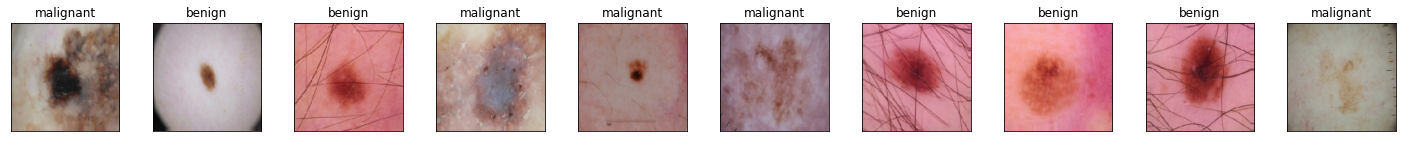

In [9]:
# Print sample training images
plotSample(training_generator, 10)

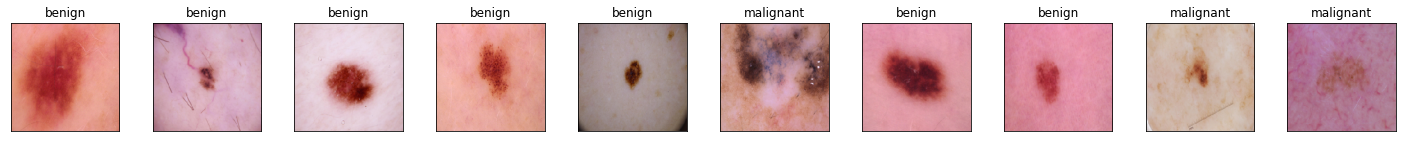

In [10]:
# Print sample validation images
plotSample(validation_generator, 10)

## CNN Model Definition & Training

In [11]:
# Model architecture definition

# Input Layer
input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)
Inp = Input(shape=input_shape, name = 'Input')

# Convolution Layer 1 with MaxPool
x = Conv2D(
    128, # Number of output filters from this convolution layer that accompanies the image
    (3, 3), # Kernel size
    padding='same', # Adds zero padding to the image so that kernel would scan the edge and corners of the image an equal number of times as other pixels
    input_shape=input_shape, 
    activation='relu', # Relu function used for activation, it trains our model faster
    bias_regularizer=tf.keras.regularizers.l2(0.01), # Reduces the bias in our activation function
    name = 'Conv_01'
    )(Inp)
x = MaxPooling2D(
    pool_size=(2, 2), # Halves the image dimensions
    name = 'MaxPool_01'
    )(x)

# Convolution Layer 2 with MaxPool
x = Conv2D(
    96, 
    (3, 3), 
    padding='same', 
    activation='relu', 
    bias_regularizer=tf.keras.regularizers.l2(0.01), 
    name = 'Conv_02'
    )(x)
x =  MaxPooling2D(
    pool_size=(2, 2), 
    name = 'MaxPool_02')(x)

# Convolution Layer 3 with MaxPool
x = Conv2D(
    64, 
    (3, 3), 
    padding='same', 
    activation='relu', 
    bias_regularizer=tf.keras.regularizers.l2(0.01), 
    name = 'Conv_03'
    )(x)
x =  MaxPooling2D(
    pool_size=(2, 2), 
    name = 'MaxPool_03')(x)

# Flatten layer for data to be passed to the artificial neural network
x = Flatten(
    name = 'Flatten' # Standard flatten layer with no augmentations
    )(x)

# Fully Connected Layer
x = Dense(
    16, 
    activation = 'relu', 
    name = 'Dense_01'
    )(x)

# Fully Connected Layer for classification of data
output = Dense(num_classes, activation='softmax', name = 'Output')(x) # Softmax to determine if final data point is benign or malignant
    
model = Model(Inp, output)

# Visualise model architecture
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 200, 200, 3)]     0         
_________________________________________________________________
Conv_01 (Conv2D)             (None, 200, 200, 128)     3584      
_________________________________________________________________
MaxPool_01 (MaxPooling2D)    (None, 100, 100, 128)     0         
_________________________________________________________________
Conv_02 (Conv2D)             (None, 100, 100, 96)      110688    
_________________________________________________________________
MaxPool_02 (MaxPooling2D)    (None, 50, 50, 96)        0         
_________________________________________________________________
Conv_03 (Conv2D)             (None, 50, 50, 64)        55360     
_________________________________________________________________
MaxPool_03 (MaxPooling2D)    (None, 25, 25, 64)        0     

In [12]:
# Define the optimizer, loss and metrics used during trainign
from keras.callbacks import EarlyStopping, ModelCheckpoint
opt = Adam(lr = 0.0001) # Standard adam optimiser
model.compile(loss = tf.keras.losses.categorical_crossentropy, # Better compared to binary cross entropy
             optimizer = opt,
             metrics = ['acc'] # Uses accuracy to gauge model progress
              )

Using TensorFlow backend.


In [13]:
# Define the number of steps the training or validation would take
training_steps = max(training_generator.samples // BATCH_SIZE, 1)
validation_steps = max(validation_generator.samples // BATCH_SIZE, 1)

training_generator.reset()  # Reset the training generator to start from the beginning

# Train the CNN
history = model.fit_generator(
    training_generator, # Training data
    steps_per_epoch = training_steps,
    epochs = EPOCHS, # Number of epochs model will run for
    validation_data = validation_generator, # Validation data
    validation_steps = validation_steps,
    verbose=1 # Display model training progress
    )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
74/74 [==============================] - 27s 361ms/step - loss: 0.6768 - acc: 0.5578 - val_loss: 0.5907 - val_acc: 0.7674
Epoch 2/20
74/74 [==============================] - 27s 359ms/step - loss: 0.5567 - acc: 0.7156 - val_loss: 0.4536 - val_acc: 0.7726
Epoch 3/20
74/74 [==============================] - 27s 360ms/step - loss: 0.4828 - acc: 0.7575 - val_loss: 0.4602 - val_acc: 0.8003
Epoch 4/20
74/74 [==============================] - 27s 359ms/step - loss: 0.4647 - acc: 0.7711 - val_loss: 0.4510 - val_acc: 0.7986
Epoch 5/20
74/74 [==============================] - 26s 356ms/step - loss: 0.4448 - acc: 0.7744 - val_loss: 0.3999 - val_acc: 0.8247
Epoch 6/20
74/74 [==============================] - 26s 355ms/step - loss: 0.4324 - acc: 0.7854 - val_loss: 0.4064 - val_acc: 0.8108
Epoch 7/20
74/74 [==============================] - 26s 354ms/step - loss: 0.4184 - acc: 0.7986 - val_loss: 0.3830 - val_acc: 

## Model Evaluation

In [14]:
def plot_train(hist, choice = 'accuracy'):
    """
    Function to plot accuracy or loss over the training iterations.
    @args:
        hist: The history saved during the model training phase
        choice: The type of function to plot. Should only be either 'accuracy' or 'loss'. Defaults to 'accuracy'.
    """
    h = hist.history
    if choice == 'accuracy':
        meas='acc'
        loc='lower right'
    else:
        meas='loss'
        loc='upper right'
    plt.plot(hist.history[meas])
    plt.plot(hist.history['val_'+meas])
    plt.title('model '+meas)
    plt.ylabel(meas)
    plt.xlabel('epoch')
    plt.ylim(ymin=0)
    plt.legend(['train', 'validation'], loc=loc)
    
def view_classify(datagen, pred_model):
    """
    Function for viewing an image and it's predicted class probabilities.
    @args:
        datagen: The image generator of the test data.
        pred_model: The trained model to use to make predictions.
    """
    # Get first batch
    images, labels = datagen.next()
    
    img = images[0]
    preds = model.predict(np.expand_dims(img, axis = 0))
    ps = preds[0]
    
    # Swap the class name and its numeric representation
    classes = sorted(datagen.class_indices, key=datagen.class_indices.get)
    
    print('Probabilities:')
    print(pd.DataFrame({'Class Label': classes, 'Probabilties': ps}))
    
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.squeeze())
    ax1.axis('off')
    ax2.set_yticks(np.arange(len(classes)))
    ax2.barh(np.arange(len(classes)), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticklabels(classes, size='small')
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

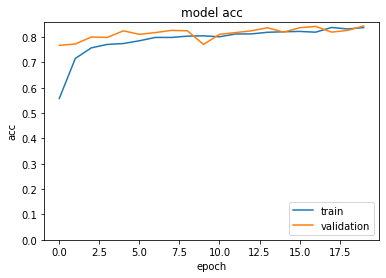

In [15]:
# Plot the Model accuracy on train and validation set
plot_train(history)

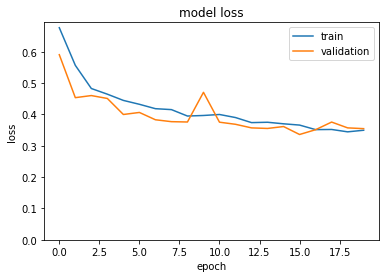

In [16]:
# Plot the Model loss on train and validation set
plot_train(history, 'loss')

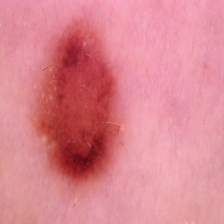

In [17]:
# Try on one image
image_check = validation_df.filename[0] # Image Path
Image(image_check)

Layer in Visualisation: Conv_01


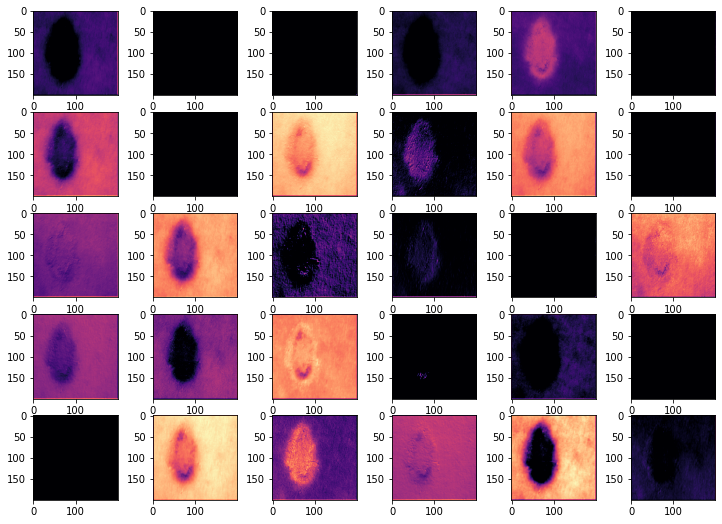

In [18]:
# Visualise how the image is seen
def display_activation(model, img_path, col_size, row_size, act_index): 
    """
    Function to plot the feature maps of the convolution networks
    @args:
      model: The trained model which contains the convolutional layers to visualise.
      img_path: The image path to the input image to the network.
      col_size: The number of columns of feature map to fill.
      row_size: The number of rows of feature map to fill.
      act_index: The desired convolution layer to visualise. The range of this index starts from the 1st convolution (0) to the last layer before Flatten/Dense
    """
    # Load and rescale the image
    img = load_img(img_path, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255. 
    
    # Make sure that the layer index to visualise is present in the network
    assert len(model.layers) > act_index
    
    layer_outputs = [layer.output for layer in model.layers[1:]]
    activation_model = Model(inputs=model.input, outputs=layer_outputs)
    activations = activation_model.predict(x)
    activation = activations[act_index]
    print('Layer in Visualisation:', model.layers[act_index+1].name)
    activation_index=0
    
    # Plot the filters
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size): 
      for col in range(0,col_size):
        ax[row][col].imshow(activation[0, :, :, activation_index], cmap='magma')
        activation_index += 1
display_activation(model, image_check, 6, 5, 0)

[[[0.6039216  0.48627454 0.59607846]
  [0.6039216  0.48235297 0.6039216 ]
  [0.6039216  0.4901961  0.60784316]
  ...
  [0.5921569  0.4784314  0.5568628 ]
  [0.5803922  0.47058827 0.5568628 ]
  [0.58431375 0.47450984 0.56078434]]

 [[0.6039216  0.48627454 0.59607846]
  [0.6039216  0.48235297 0.60784316]
  [0.6039216  0.4901961  0.60784316]
  ...
  [0.58431375 0.47058827 0.54901963]
  [0.57254905 0.45882356 0.5372549 ]
  [0.5921569  0.4666667  0.5568628 ]]

 [[0.5921569  0.47450984 0.58431375]
  [0.59607846 0.49411768 0.60784316]
  [0.60784316 0.48627454 0.60784316]
  ...
  [0.58431375 0.47450984 0.53333336]
  [0.5803922  0.45882356 0.5294118 ]
  [0.5882353  0.47450984 0.56078434]]

 ...

 [[0.5411765  0.4156863  0.4666667 ]
  [0.5411765  0.4156863  0.4666667 ]
  [0.5294118  0.4039216  0.454902  ]
  ...
  [0.5529412  0.45882356 0.5529412 ]
  [0.54901963 0.454902   0.54901963]
  [0.5529412  0.45098042 0.54901963]]

 [[0.5372549  0.41176474 0.46274513]
  [0.5254902  0.4039216  0.46274513]


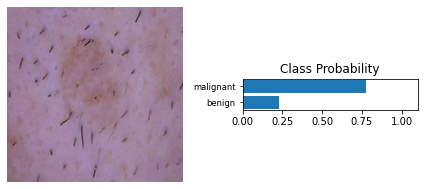

In [19]:
def print_preds(datagen, pred_model):
    # Get first batch
    images, labels = datagen.next()
    
    img = images[0]
    preds = model.predict(np.expand_dims(img, axis = 0))
    ps = preds[0]
    print(img)
    # Swap the class name and its numeric representation
    classes = sorted(datagen.class_indices, key=datagen.class_indices.get)
    
    print('Probabilities:')
    print(pd.DataFrame({'Class Label': classes, 'Probabilties': ps}))
    if labels[0][0] == 1.0:
        print('Actual Label: Benign')
    elif labels[0][1] == 1.0:
        print('Actual Label: Malignant')
    else:
        print('Actual Label: Label Error')
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.squeeze())
    ax1.axis('off')
    ax2.set_yticks(np.arange(len(classes)))
    ax2.barh(np.arange(len(classes)), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticklabels(classes, size='small')
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()
print_preds(validation_generator, model)

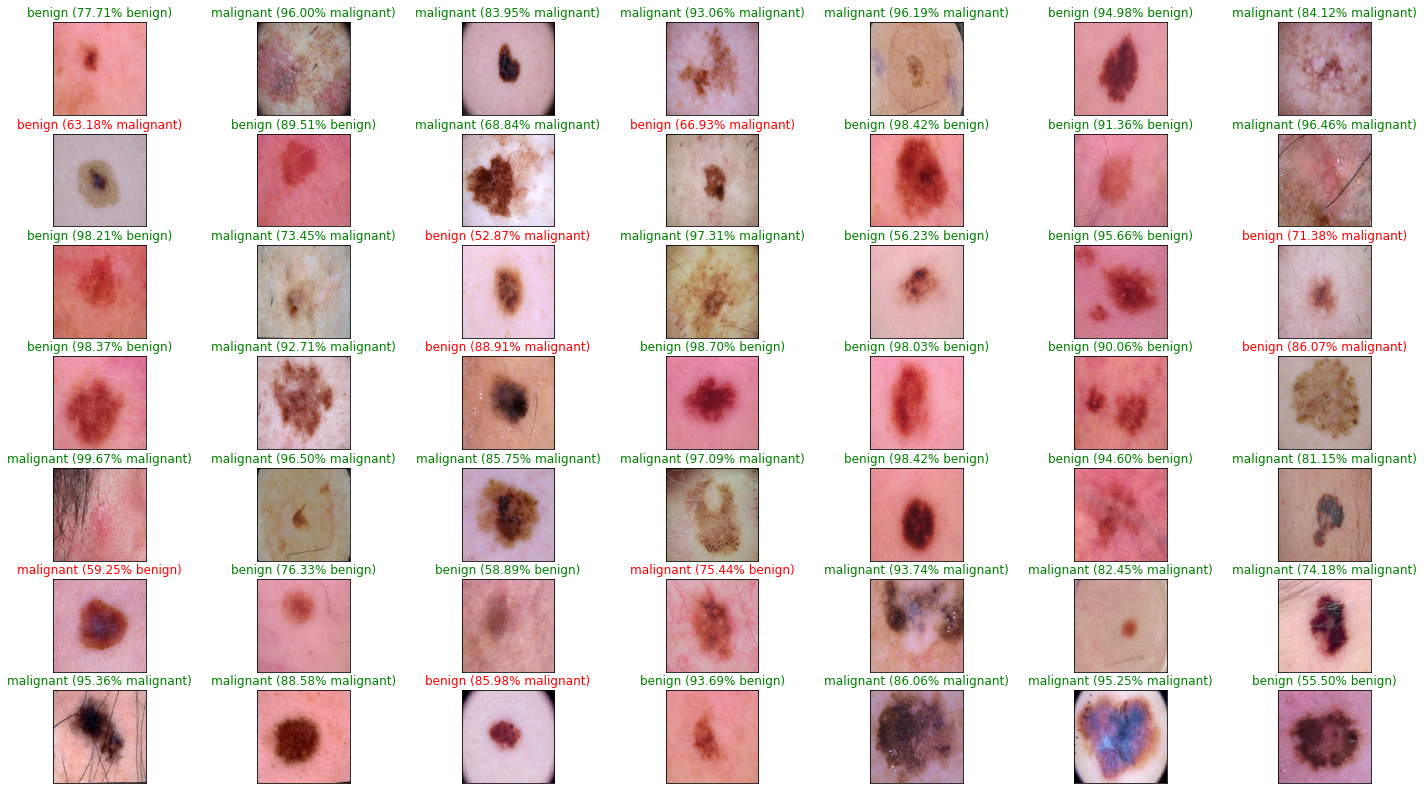

In [20]:
plotSample(validation_generator, 49, model, 7)

In [21]:

# Compute the overall accuracy of the model with validation dataset
metrics = model.evaluate_generator(validation_generator)
model.evaluate(validation_generator)
print("model accuracy:", metrics[1])

Instructions for updating:
Please use Model.evaluate, which supports generators.
19/19 [==============================] - 2s 101ms/step - loss: 0.3664 - acc: 0.8381
model accuracy: 0.8380634188652039


In [22]:
# Save the model into a .hdf5 file for deployment on website
model.save("skinpredv5.hdf5", include_optimizer=False)